In [2]:
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
dftrain = pd.read_csv("data/plasticc_train_metadata.csv")

dftest = pd.read_csv("data/plasticc_test_metadata.csv")

dftest = dftest[:20000]

dftest['target'] = dftest['true_target']

dftrain = pd.concat([dftrain, dftest], axis=0, ignore_index=True)

model_nums = {90:'SN Ia', 67:'SNIa-91bg', 52:'SNIax', 42:'SNII', 62:'SNIbc', 95:'SLSN-I', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf', 16:'EB', 53:'Mira', 6:'muLens-Single', 991:'muLens-Binary', 992:'ILOT', 993:'CaRT', 994:'PISN', 995:'muLens-String'}

sn_models = [90, 67, 52, 42, 62, 95, 15]

dftrain = dftrain[dftrain['target'].isin(sn_models)]

dftrain['target_names'] = dftrain['target'].map(model_nums)

In [5]:
print(dftrain)

       object_id        ra     decl  ddf_bool  hostgal_specz  hostgal_photoz  \
2            730   33.5742  -6.5796         1          0.232           0.226   
3            745    0.1899 -45.5867         1          0.304           0.281   
4           1124  352.7113 -63.8237         1          0.193           0.241   
6           1598  347.8467 -64.7609         1          0.135           0.182   
7           1632  348.5959 -63.0726         1          0.686           0.701   
...          ...       ...      ...       ...            ...             ...   
27843     209005   53.0859 -28.1222         1          0.490           0.503   
27844     209007    1.6667 -44.3998         1         -9.000           0.466   
27845     209011    0.1907 -45.7840         1         -9.000           0.618   
27846     209025  148.8867   2.6867         1         -9.000           0.604   
27847     209057  346.5625 -63.4483         1         -9.000           0.707   

       hostgal_photoz_err  distmod  mwe

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'PLAsTiCC Training Set ($N=24577$)')

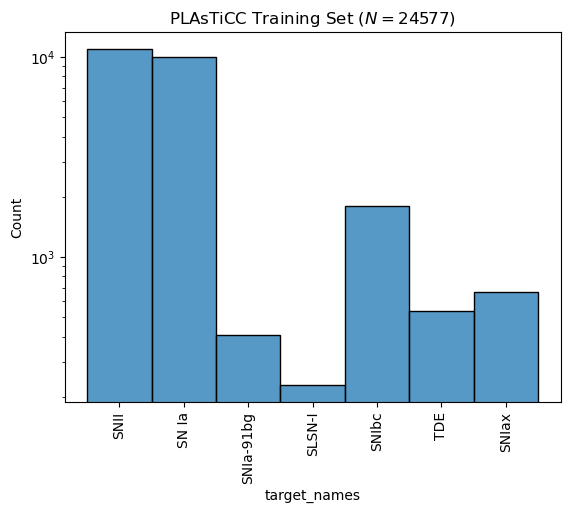

In [6]:
sns.histplot(dftrain['target_names'])
plt.yscale("log")
plt.xticks(rotation=90);
plt.title("PLAsTiCC Training Set ($N=%i$)"%len(dftrain))

In [7]:
lcs = pd.read_csv("data/plasticc_train_lightcurves.csv")
lcs_test = pd.read_csv("data/plasticc_test_lightcurves_01.csv")

lcs = pd.concat([lcs, lcs_test[:3000000]], axis=0, ignore_index=True)

# lcs = pd.merge(lcs, dftrain, on='object_id', how='inner')
lcs['passband']

0          2
1          1
2          3
3          4
4          2
          ..
4421700    0
4421701    0
4421702    0
4421703    0
4421704    2
Name: passband, Length: 4421705, dtype: int64

In [8]:
# #map passband idx to passband name
# lcs['passband_name'] = ["ugrizY"[i] for i in lcs['passband']]
# lcs_detected = lcs[lcs['detected_bool'] == True]
# cols = sns.color_palette("Spectral_r", 6)
# VRO_bands = "ugrizY"

# transients = np.unique(lcs_detected['object_id'])


# fig, axs = plt.subplots(4, 5, figsize=(20, 15), sharex=True, sharey=False)
# axs = axs.ravel()

# for j in np.arange(20):
#     transient = transients[j]
#     lc = lcs_detected[lcs_detected['object_id'] == transient]
#     for i in np.arange(len(VRO_bands)):
#         band = VRO_bands[i]
#         lc_band = lc[lc['passband_name'] == band]
#         axs[j].errorbar(lc_band['mjd'] - np.nanmin(lc['mjd']), lc_band['flux'], yerr=lc_band['flux_err'], fmt='o', mec='k', c=cols[i], label=band)
#     axs[j].set_ylabel("Flux")
#     axs[j].set_title(dftrain.loc[dftrain['object_id'] == transient, 'target_names'].values[0])
# axs[-1].legend()
# axs[0].set_xlim((-10, 200));
# for idx in np.arange(15, 20):
#     axs[idx].set_xlabel("Days since Discovery");
# fig.tight_layout(w_pad=0.1, h_pad=0.3)

In [9]:
columns = ['mjd', 'passband', 'flux', 'flux_err']

# filter wavelengths in angstroms
wavelengths = {
    0: 3671,
    1: 4827,
    2: 6223,
    3: 7546,
    4: 8691,
    5: 9712
}
print(lcs['passband'])
lcs['passband'] = lcs['passband'].map(wavelengths)
lcs['passband']

0          2
1          1
2          3
3          4
4          2
          ..
4421700    0
4421701    0
4421702    0
4421703    0
4421704    2
Name: passband, Length: 4421705, dtype: int64


0          6223
1          4827
2          7546
3          8691
4          6223
           ... 
4421700    3671
4421701    3671
4421702    3671
4421703    3671
4421704    6223
Name: passband, Length: 4421705, dtype: int64

In [10]:
# Prepare Train Data
x_train = []
y_train = []

max_length = 352

for id in dftrain['object_id']:
    if len(lcs[lcs['object_id'] == id]) == 0:
        continue
    x_train.append(lcs[lcs['object_id'] == id][columns].reset_index())
    y_train.append(dftrain[dftrain['object_id'] == id]['true_peakmjd'].tolist())
    while len(x_train[-1].index) < max_length:
        x_train[-1].loc[len(x_train[-1].index)] = [len(x_train[-1].index), 0, 0, 0, 0]
    x_train[-1] = x_train[-1][columns]


In [11]:
# Prepare Test and Validation Data
for i in range(len(x_train)):
    try:
        x_train[i] = x_train[i].values
    except AttributeError:
        pass
    y_train[i][0] -= 59000
    y_train[i][0] /= 2000
    for j in range(len(x_train[i])):
        if x_train[i][j][0] == 0:
            continue
        x_train[i][j][0] -= 59000
        x_train[i][j][0] /= 2000
        x_train[i][j][1] -= 3671
        x_train[i][j][1] /= 6041

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

# dftest = pd.read_csv('data/plasticc_test_metadata.csv')

# lcs_test = pd.read_csv('data/plasticc_test_lightcurves_01.csv')
# lcs_val = pd.read_csv('data/plasticc_test_lightcurves_02.csv')

# print(lcs, lcs_test, lcs_val)

# lcs_test['passband'] = lcs_test['passband'].map(wavelengths)
# lcs_val['passband'] = lcs_val['passband'].map(wavelengths)

# dftest = dftest[dftest['true_target'].isin(sn_models)]

# dftest['target_names'] = dftest['true_target'].map(model_nums)

# # lcs_test = pd.merge(lcs_test, dftest, on='object_id', how='inner')
# # lcs_val = pd.merge(lcs_val, dftest, on='object_id', how='inner')

# x_test, x_val, y_test, y_val = [], [], [], []

In [12]:
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=45)

In [13]:
# for id in dftest['object_id']:
#     # print(id)
#     if len(lcs_test[lcs_test['object_id'] == id]) > 0:
#         # print("test: " + id, flush=True)
#         x_test.append(lcs_test[lcs_test['object_id'] == id][columns].reset_index())
#         y_test.append(dftest[dftest['object_id'] == id]['true_peakmjd'])
#         print(len(x_test[-1].index)
#         # while len(x_test[-1].index) < max_length:
#         #     x_test[-1].loc[len(x_test[-1].index)] = [len(x_test[-1].index), 0, 0, 0, 0]
#         # x_test[-1] = x_test[-1][columns]



In [14]:
# for id in dftest['object_id']:
#     if len(lcs_val[lcs_val['object_id'] == id]) > 0:
#         # print("val: " + id, flush=True)
#         x_val.append(lcs_val[lcs_val['object_id'] == id][columns].reset_index())
#         y_val.append(dftest[dftest['object_id'] == id]['true_peakmjd'])
#         while len(x_val[-1].index) < max_length:
#             x_val[-1].loc[len(x_val[-1].index)] = [len(x_val[-1].index), 0, 0, 0, 0]
#         x_val[-1] = x_val[-1][columns]

In [15]:
print(np.array(x_train).shape)
np.array(y_train).shape 

(11132, 352, 4)


(11132, 1)

In [16]:
# Build Model

import tensorflow as tf
# import tensorflow_probability as tfp

tf.random.set_seed(1)

model = tf.keras.Sequential([
    tf.keras.layers.Input((352, 4)),
    tf.keras.layers.Masking(mask_value=np.array([0, 0, 0, 0])),
    tf.keras.layers.GRU(50, return_sequences=True, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(50,activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])
    # tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[..., :1],
                           #scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])))])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mean_squared_error')
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 352, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 352, 50)        │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 352, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,751 (92.78 KB)

 Trainable params: 23,751 (92.78 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
### Train Model
model.fit(np.array(x_train), np.array(y_train), epochs=50, validation_data=(np.array(x_val), np.array(y_val)))



Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 61s 171ms/step - loss: 0.0135 - val_loss: 0.0013
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - loss: 0.0015 - val_loss: 9.2714e-04
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 62s 177ms/step - loss: 0.0010 - val_loss: 6.4258e-04
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 69s 197ms/step - loss: 9.5701e-04 - val_loss: 9.0905e-04
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 61s 175ms/step - loss: 8.9973e-04 - val_loss: 0.0011
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 62s 177ms/step - loss: 8.2432e-04 - val_loss: 8.1232e-04
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - loss: 6.9237e-04 - val_loss: 6.2596e-04
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - loss: 7.7267e-04 - val_loss: 7.1814e-04
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 73s 209ms/step - loss: 7.6949e-04 - val_loss: 7.0740e-04
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 75s 215ms/step -

In [44]:
y_pred = model.predict(np.array(x_test))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [46]:
for i in range(len(x_test)):
    print(y_pred[i][0] * 2000 - y_test[i][0] * 2000)

0.6098035583490855
8.98245072174177
26.7697274703969
21.822899543760286
-16.163721321107005
45.31707896423177
45.50549581908854
174.64682095337048
42.15357749938994
-20.624895965578617
-31.20539305877901
9.673278793336067
-81.12982303619356
-17.6012771301248
-83.85079859161488
-21.47744052886992
45.966936416625686
59.255574958799116
-7.400332656863611
196.96851308059559
-71.8394653472933
-40.57601071929821
-43.829242568972404
69.89586235809111
243.1768824729952
-128.84414468384057
53.12070771789877
-68.3109432449346
37.421067424773355
95.81834075928055
74.2745612525905
41.88169906997791
76.64989355468424
125.013472099301
-7.002864734648028
95.19492113494925
123.11483258819499
59.106332778930664
37.48260589980782
185.8823787651054
-12.935238395693887
20.286670906069048
170.07689763641247
133.15752698516735
40.738652244566765
-9.3239335174585
-4.848901306155312
101.04542175293318
-73.2734676589971
89.30532252883859
-27.387424484251824
104.48544069671334
71.97781465911976
133.375277503968